In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATv2Conv, HeteroConv

In [6]:
hetero_data = torch.load('data/graph_biobert_hetero.pt')
print(hetero_data)

HeteroData(
  miRNA={ x=[512, 768] },
  PCG={ x=[1717, 768] },
  TF={ x=[336, 768] },
  lncRNA={ x=[1333, 768] },
  snoRNA={ x=[3, 768] },
  circRNA={ x=[7, 768] },
  (lncRNA, regulates, miRNA)={
    edge_index=[2, 1088],
    edge_attr=[1088, 13],
  },
  (lncRNA, regulates, PCG)={
    edge_index=[2, 5029],
    edge_attr=[5029, 13],
  },
  (lncRNA, regulates, TF)={
    edge_index=[2, 1570],
    edge_attr=[1570, 13],
  },
  (PCG, regulates, miRNA)={
    edge_index=[2, 11],
    edge_attr=[11, 13],
  },
  (TF, regulates, lncRNA)={
    edge_index=[2, 303],
    edge_attr=[303, 13],
  },
  (lncRNA, regulates, lncRNA)={
    edge_index=[2, 34],
    edge_attr=[34, 13],
  },
  (miRNA, regulates, lncRNA)={
    edge_index=[2, 82],
    edge_attr=[82, 13],
  },
  (PCG, regulates, PCG)={
    edge_index=[2, 36],
    edge_attr=[36, 13],
  },
  (circRNA, regulates, miRNA)={
    edge_index=[2, 3],
    edge_attr=[3, 13],
  },
  (circRNA, regulates, PCG)={
    edge_index=[2, 9],
    edge_attr=[9, 13],
  },


In [13]:
class HeteroGNNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, metadata, edge_dim, hidden_channels=64, heads=2):
        super().__init__()

        # Build conv layers for each edge type using GATv2Conv
        self.convs = {
            edge_type: GATv2Conv(
                in_channels=in_channels,
                out_channels=out_channels,
                edge_dim=edge_dim,            # use edge_attr (13-dim)
                heads=heads,
                concat=False,
                add_self_loops=False          # required to avoid error
            )
            for edge_type in metadata[1]      # metadata[1] = edge types
        }

        # Wrap them in HeteroConv
        self.hetero_conv = HeteroConv(self.convs, aggr='sum')

        # Add LayerNorm for each node type
        self.norms = nn.ModuleDict({
            node_type: nn.LayerNorm(out_channels)
            for node_type in metadata[0]     # metadata[0] = node types
        })

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Apply heterogeneous GATv2Conv with edge attributes
        out_dict = self.hetero_conv(x_dict, edge_index_dict, edge_attr_dict)

        # Normalize embeddings
        out_dict = {
            node_type: self.norms[node_type](x)
            for node_type, x in out_dict.items()
        }
        return out_dict


In [14]:
# Create encoder
metadata = hetero_data.metadata()

encoder = HeteroGNNEncoder(
    in_channels=768,
    out_channels=128,
    metadata=metadata,
    edge_dim=13,  # edge_attr size
)

# Forward pass (no gradients needed)
with torch.no_grad():
    embeddings = encoder(
        hetero_data.x_dict,
        hetero_data.edge_index_dict,
        hetero_data.edge_attr_dict
    )

# Print shape of embeddings
for node_type, emb in embeddings.items():
    print(f"{node_type} embedding shape: {emb.shape}")


miRNA embedding shape: torch.Size([512, 128])
PCG embedding shape: torch.Size([1717, 128])
TF embedding shape: torch.Size([336, 128])
lncRNA embedding shape: torch.Size([1333, 128])
snoRNA embedding shape: torch.Size([3, 128])
circRNA embedding shape: torch.Size([7, 128])


In [25]:
## save the embedding 

import torch
import os

save_dir = "embeddings_GATv2Conv"
os.makedirs(save_dir, exist_ok=True)

for node_type, emb in embeddings.items():
    torch.save(emb.cpu(), os.path.join(save_dir, f"{node_type}_embedding.pt"))
    print(f"Saved: {node_type}_embedding.pt, shape = {emb.shape}")


Saved: miRNA_embedding.pt, shape = torch.Size([512, 128])
Saved: PCG_embedding.pt, shape = torch.Size([1717, 128])
Saved: TF_embedding.pt, shape = torch.Size([336, 128])
Saved: lncRNA_embedding.pt, shape = torch.Size([1333, 128])
Saved: snoRNA_embedding.pt, shape = torch.Size([3, 128])
Saved: circRNA_embedding.pt, shape = torch.Size([7, 128])


In [17]:
# Combine all node embeddings into one matrix
all_embs = []
all_labels = []

for node_type, emb in embeddings.items():
    all_embs.append(emb)
    all_labels.extend([node_type] * emb.shape[0])

all_embs = torch.cat(all_embs, dim=0).cpu().numpy()
all_labels = np.array(all_labels)


In [18]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(all_embs)


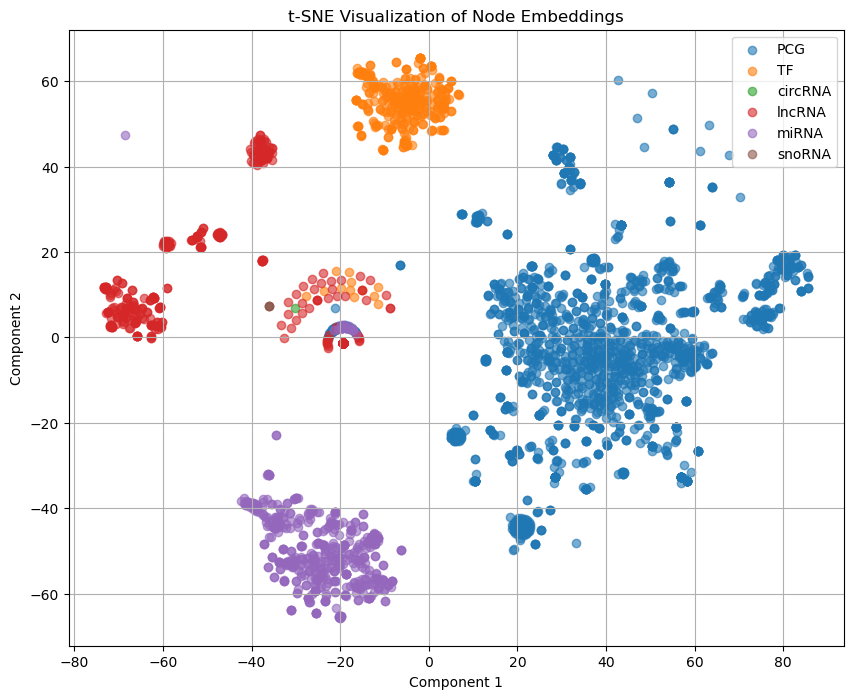

In [19]:
# Plot with color per node type
plt.figure(figsize=(10, 8))
for node_type in np.unique(all_labels):
    idx = all_labels == node_type
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=node_type, alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


In [21]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(all_embs)  

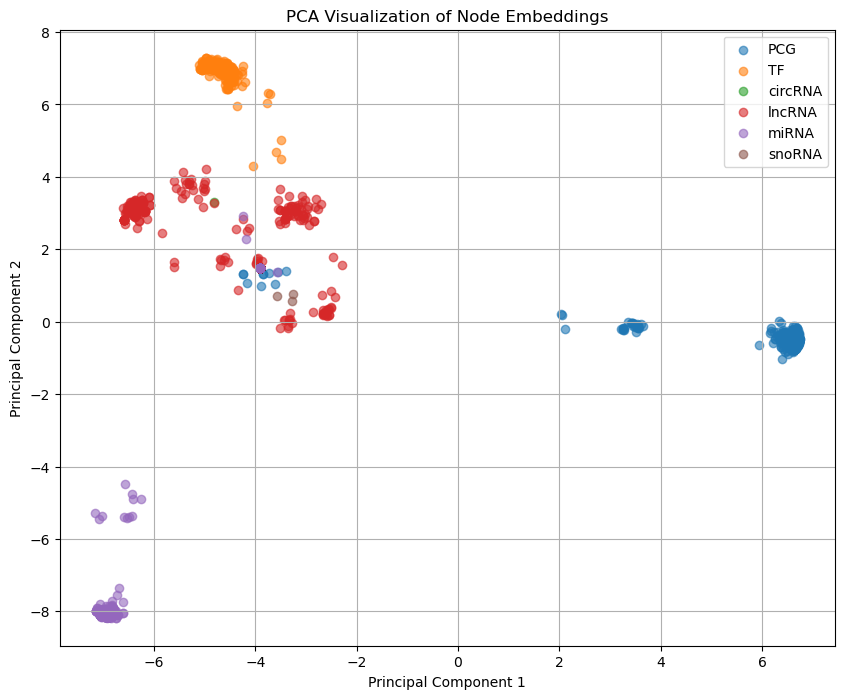

In [22]:
# Plot PCA result
plt.figure(figsize=(10, 8))
for node_type in np.unique(all_labels):
    idx = all_labels == node_type
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=node_type, alpha=0.6)

plt.legend()
plt.title("PCA Visualization of Node Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
